### Loading a single simulation

In [40]:
import pandas as pd
from pathlib import Path
import glob
import yaml
import math
from typing import List, Tuple, Dict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [16]:
def read_config(path: Path) -> Dict:
    with path.open("r") as config_file:
        config = yaml.safe_load(config_file)
    return config

def normalize_config_output_path(config: Dict) -> Dict:
    config["output_path"] = Path(config["output_path"])
    return config

def read_simulation_statistics(config: Dict):
    fields_to_add_from_config = [
        "slope",
        "effective_radius_multiplier",
        "r_stat_multiplier",
        "min_rim_percentage"
    ]
    
    # Read all statistics parquet files
    filenames = config["output_path"].glob("statistics*.parquet")
    
    dataframes = []
    for filename in filenames:
        df = pd.read_parquet(filename)
        dataframes.append(df)
    df = pd.concat(dataframes)
    df = df.sort_values(by=["crater_id"]).reset_index(drop=True)
    
    return df

In [236]:
base_path = "/data/saturation/central_composite_design/ccd4"

In [237]:
completed_filenames = list(Path(base_path).glob("*/*/completed.txt"))
configs = map(lambda x: x.parent / "config.yaml", completed_filenames)
configs = map(read_config, configs)
configs = list(map(normalize_config_output_path, configs))

In [238]:
# Take a look at configs
# [(index, x["simulation_name"]) for index, x in enumerate(configs) if x["min_rim_percentage"] > 0.6 and x["effective_radius_multiplier"] > 1.8]
sorted([(index, x["simulation_name"]) for index, x in enumerate(configs) if x["min_rim_percentage"] > 0.45 and x["min_rim_percentage"] < 0.55 and x["effective_radius_multiplier"] < 1.5], key=lambda x: x[1])

[(79, 'central_composite_design_point_1.091_0.500_8.996_2.997_1'),
 (12, 'central_composite_design_point_1.093_0.500_9.020_2.042_1'),
 (29, 'central_composite_design_point_1.095_0.495_6.023_2.044_1'),
 (163, 'central_composite_design_point_1.096_0.503_3.002_2.041_1'),
 (111, 'central_composite_design_point_1.097_0.500_6.040_2.990_1'),
 (108, 'central_composite_design_point_1.097_0.500_9.009_2.994_1'),
 (205, 'central_composite_design_point_1.098_0.495_3.006_2.054_1'),
 (171, 'central_composite_design_point_1.098_0.500_6.030_2.059_1'),
 (170, 'central_composite_design_point_1.098_0.500_8.995_1.100_1'),
 (159, 'central_composite_design_point_1.099_0.497_2.974_3.002_1'),
 (229, 'central_composite_design_point_1.099_0.504_9.013_3.005_1'),
 (2, 'central_composite_design_point_1.100_0.499_5.959_3.009_1'),
 (160, 'central_composite_design_point_1.100_0.501_8.949_1.094_1'),
 (204, 'central_composite_design_point_1.101_0.498_3.021_1.100_1'),
 (57, 'central_composite_design_point_1.101_0.498_5.9

In [239]:
# config = configs[50] # Slope ~3, r_stat ~3, min_rim ~0.5, eff ~1.9
#config = configs[92] # High destruction plus slope ~3
# config = configs[212] # Center point
config = configs[198] # Trickier example for threshold: Low destruction: min_rim ~0.5, eff ~1.1, r_stat ~3, slope ~2
slope = config["slope"]
r_min = config["min_crater_radius"]
study_region_size = config["study_region_size"]
window_size = 2500

df = read_simulation_statistics(config)

In [240]:
config

{'effective_radius_multiplier': 1.4994452682189006,
 'max_crater_radius': 2500,
 'min_crater_radius': 10,
 'min_rim_percentage': 0.6989439188982363,
 'output_path': PosixPath('/data/saturation/central_composite_design/ccd4/central_composite_design_point_1.499_0.699_2.998_2.995/1'),
 'r_stat_multiplier': 2.998176176819651,
 'simulation_id': 1,
 'simulation_name': 'central_composite_design_point_1.499_0.699_2.998_2.995_1',
 'slope': 2.994753596977993,
 'spatial_hash_cell_size': 50,
 'stop_condition': {'name': 'areal_density', 'percentage_increase': 0.01},
 'study_region_padding': 1250,
 'study_region_size': 10000,
 'write_image_cadence': 0,
 'write_state_cadence': 0,
 'write_statistics_cadence': 100000}

In [241]:
slope

2.994753596977993

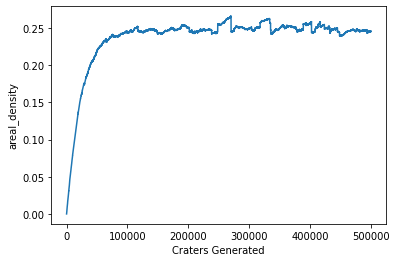

In [242]:
metric = "areal_density"

plt.plot(df.n_craters_added_in_study_region, df[metric])
plt.xlabel("Craters Generated")
plt.ylabel(metric)
plt.show()

In [243]:
df.columns

Index(['crater_id', 'n_craters_added_in_study_region',
       'n_craters_in_study_region', 'areal_density', 'z', 'za'],
      dtype='object')

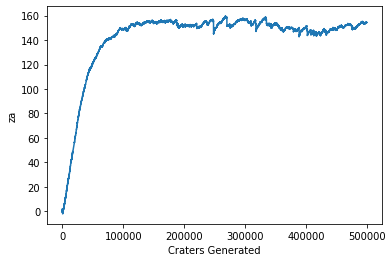

In [244]:
metric = "za"

plt.plot(df.n_craters_added_in_study_region, df[metric])
plt.xlabel("Craters Generated")
plt.ylabel(metric)
plt.show()

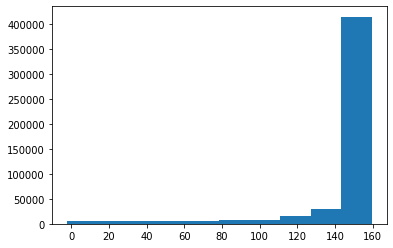

In [245]:
# Overall
metric = "za"

plt.hist(df[metric])
plt.show()

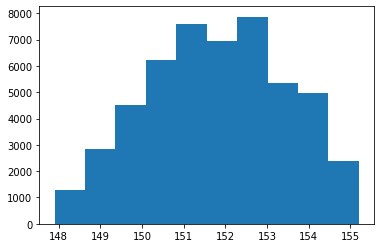

In [246]:
# Late
metric = "za"

plt.hist(df.iloc[-50000:][metric])
plt.show()

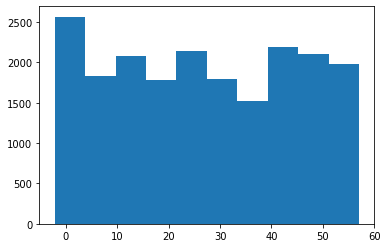

In [247]:
# Early
metric = "za"

plt.hist(df.iloc[:20000][metric])
plt.show()

In [248]:
# Calculate the expected increase in areal density if a new crater forms without removals or overlap
expected_mean_r = (slope * r_min) / (slope - 1)
expected_increase = expected_mean_r**2 * math.pi / study_region_size**2
expected_increase

7.080982961519473e-06

In [220]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

y = df[metric]
X = sm.add_constant(df.n_craters_added_in_study_region)

rols = RollingOLS(y, X, window=window_size, min_nobs=window_size)
rres = rols.fit()

params = rres.params.copy()
params.index = np.arange(1, params.shape[0] + 1)

In [221]:
cis = rres.conf_int()["n_craters_added_in_study_region"]

In [222]:
factor = .01
threshold_increase = factor * expected_increase

saturation_point = cis[(cis.lower < threshold_increase) & (cis.upper > threshold_increase)].index[0]
saturation_point

21171

In [223]:
# Let's take a look at the regression at this saturation point
subset = df.iloc[saturation_point:saturation_point + window_size]
model = sm.OLS(subset[metric], sm.add_constant(subset.n_craters_added_in_study_region))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          areal_density   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     5077.
Date:                Sat, 21 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:41:00   Log-Likelihood:                 8431.8
No. Observations:                2500   AIC:                        -1.686e+04
Df Residuals:                    2498   BIC:                        -1.685e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0993      0.005     19.234      0.000       0.089       0.109
n_craters_added_in_study_region  1.639e-05    2.3e-07     71.255      0.000    1.59e-05    1.68e-05
==============================================================================
Omnibus:                      106.476   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.049
Skew:                           0.222   Prob(JB):                     9.13e-14
Kurtosis:                       2.384   Cond. No.                     6.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [224]:
# Regression deeper into the simulation
# Coefficient for n_craters is very small and negative
subset = df.iloc[-150000:-100000]
model = sm.OLS(subset[metric], sm.add_constant(subset.n_craters_added_in_study_region))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          areal_density   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     9617.
Date:                Sat, 21 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:41:00   Log-Likelihood:             1.6202e+05
No. Observations:               50000   AIC:                        -3.240e+05
Df Residuals:                   49998   BIC:                        -3.240e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.6331      0.000   1714.170      0.000       0.632       0.634
n_craters_added_in_study_region -2.879e-07   2.94e-09    -98.066      0.000   -2.94e-07   -2.82e-07
==============================================================================
Omnibus:                    16292.068   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2353.252
Skew:                           0.023   Prob(JB):                         0.00
Kurtosis:                       1.938   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [225]:
# Regression far into the simulation
# Coefficient for n_craters is very small and negative
subset = df.iloc[-50000:]
model = sm.OLS(subset[metric], sm.add_constant(subset.n_craters_added_in_study_region))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          areal_density   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                 3.430e+04
Date:                Sat, 21 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:41:00   Log-Likelihood:             1.1633e+05
No. Observations:               50000   AIC:                        -2.326e+05
Df Residuals:                   49998   BIC:                        -2.326e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.9068      0.002    549.420      0.000       0.904       0.910
n_craters_added_in_study_region -1.356e-06   7.32e-09   -185.190      0.000   -1.37e-06   -1.34e-06
==============================================================================
Omnibus:                     2034.286   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2315.903
Skew:                           0.497   Prob(JB):                         0.00
Kurtosis:                       3.350   Cond. No.                     3.52e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.52e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

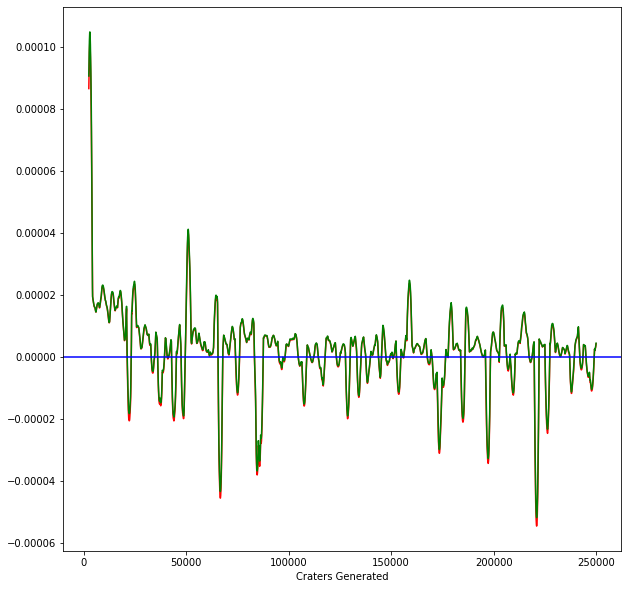

In [226]:
plt.figure(figsize=(10, 10))
plt.plot(df.n_craters_added_in_study_region, cis.lower, color="r")
plt.plot(df.n_craters_added_in_study_region, cis.upper, color="g")
plt.axhline(y=threshold_increase, color="b")
plt.xlabel("Craters Generated")

plt.show()